In [ ]:
# !pip install ccxt mpl_finance

In [2]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpdates
%matplotlib inline

In [17]:
class CCX:

  def __init__(self, xch):
      # self.ticker = ticker
      self.xch = xch
  
  def extractData(self, ticker):
    
    if self.xch != "binance":
      print("Unknown exchange . Program works only for Binance for now !!")
      return None

    exchange = ccxt.binance()
    if exchange.has['fetchOHLCV']:
      since = exchange.parse8601("2020-11-01T00:00:00Z")
      # print(since)

      all_orders = []
      while since < exchange.milliseconds():
          limit = 20  # change for your limit
          ohlcv = exchange.fetch_ohlcv(symbol = ticker, since = since, timeframe = "1d", limit = limit)
          if len(ohlcv) >0:
            # dt = (datetime.fromtimestamp(since) - timedelta(hours=2)).strftime('%Y-%m-%d %H:%M:%S')
            # print(f"Extracting data for date {dt}")
            since= ohlcv[len(ohlcv)-1][0] + 1
            all_orders += ohlcv
          else:
              break
  
    return all_orders

  def cleanData(self,ohlcv_list):
    temp = []
    for i in ohlcv_list:
      timestamp_with_ms = i[0]
      dt = datetime.datetime.fromtimestamp(timestamp_with_ms / 1000)
      formated_time = dt.strftime("%Y-%m-%d %H:%M%S.%f")[:-3]
      i[0] = dt
      temp.append(i)
    
    return temp

  def createDataFrame(self,ohlc_list):
    ohlcv_list = self.cleanData(ohlcv_list= ohlc_list)
    df = pd.DataFrame(ohlcv_list, columns= ["date", "o", "h", "l" , "c", "v"])
    print("DataFrame created")
    print(df.head())

    return df

In [18]:
cc = CCX(xch= "binance")

In [19]:
data = cc.extractData(ticker= "BTC/USDT")

In [20]:
len(data)

540

In [21]:
df = cc.createDataFrame(ohlc_list= data)

DataFrame created
        date         o         h         l         c              v
0 2020-11-01  13791.00  13895.00  13603.00  13761.50   36285.648526
1 2020-11-02  13761.49  13830.00  13195.05  13549.37   64566.421908
2 2020-11-03  13549.63  14066.11  13284.99  14023.53   74115.630787
3 2020-11-04  14023.53  14259.00  13525.00  14144.01   93016.988262
4 2020-11-05  14144.01  15750.00  14093.56  15590.02  143741.522673


In [22]:
class PlotGraph:

  def __init__(self,df):
    self.df = df
    self.df['ewm200'] = df['c'].ewm(span=200,min_periods=0,adjust=False,ignore_na=False).mean()
  
  def createLineChart(self):
    plt.figure(figsize = (16,8))
    plt.plot(self.df.date,self.df.c, color = "black", label = "Closing Value")
    plt.plot(self.df.date, self.df["ewm200"] ,color = "teal", label = "EWMA 200")

    plt.title("Closing price of Bitcoin vs EMWA 200")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Bitcoin Price")
    plt.show()

    return None

  def createCandleStick(self):
    Df = self.df.copy()
    # apply map function
    try:
      Df['date'] = Df['date'].map(mpdates.date2num)
    except:
      pass

    # creating Subplots
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(8)
    
    # plotting the data
    candlestick_ohlc(ax, Df[["date","o","h","l","c"]].values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    plt.plot(df.date, df["ewm200"] ,color = "teal", label = "EWMA 200")
    # allow grid
    # ax.grid(True)
    
    # Setting labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    
    # setting title
    plt.title('Bitcoin Candlesticks')
    
    # Formatting Date
    date_format = mpdates.DateFormatter('%d-%m-%Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    
    fig.tight_layout()
    
    # show the plot
    plt.show()

    return None

In [23]:
pg = PlotGraph(df = df)

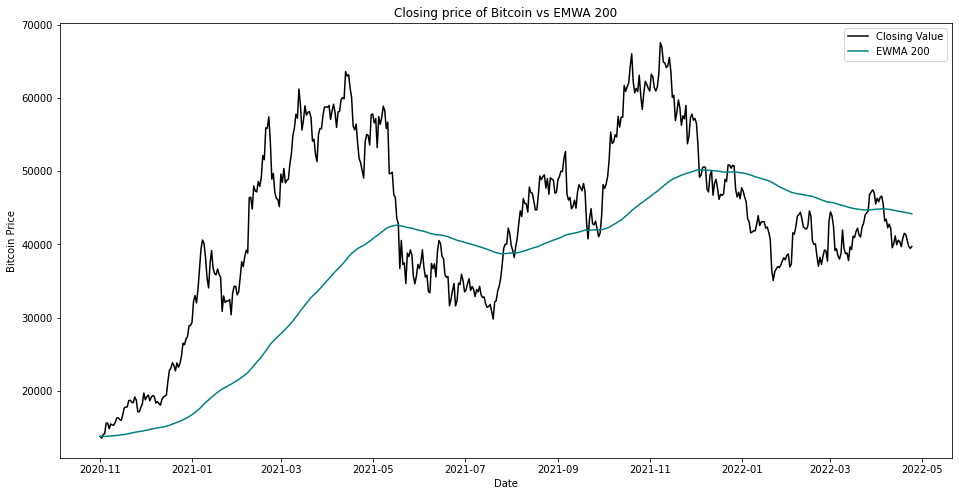

In [24]:
pg.createLineChart()

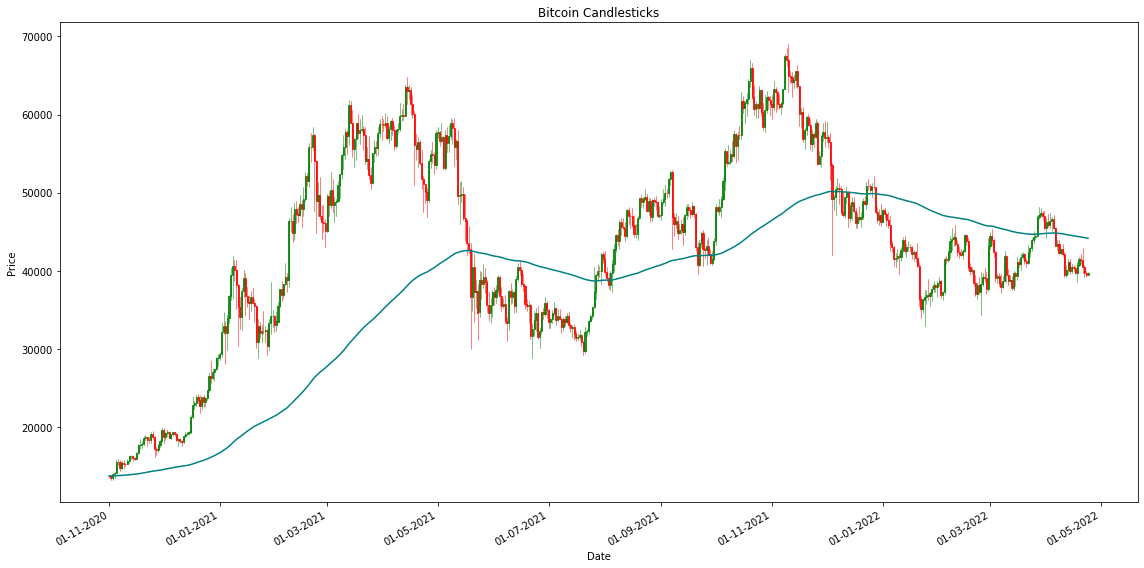

In [26]:
pg.createCandleStick()